In [5]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import datetime as dt
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate

Loading dataset

# Data Descripton
Data Set Information:

The experimental testbed for occupancy estimation was deployed in a 6m Ã— 4.6m room. The setup consisted of 7 sensor nodes and one edge node in a star configuration with the sensor nodes transmitting data to the edge every 30s using wireless transceivers. No HVAC systems were in use while the dataset was being collected.

Five different types of non-intrusive sensors were used in this experiment: temperature, light, sound, CO2 and digital passive infrared (PIR). The CO2, sound and PIR sensors needed manual calibration. For the CO2 sensor, zero-point calibration was manually done before its first use by keeping it in a clean environment for over 20 minutes and then pulling the calibration pin (HD pin) low for over 7s. The sound sensor is essentially a microphone with a variable-gain analog amplifier attached to it. Therefore, the output of this sensor is analog which is read by the microcontrollerâ€™s ADC in volts. The potentiometer tied to the gain of the amplifier was adjusted to ensure the highest sensitivity. The PIR sensor has two trimpots: one to tweak the sensitivity and the other to tweak the time for which the output stays high after detecting motion. Both of these were adjusted to the highest values. Sensor nodes S1-S4 consisted of temperature, light and sound sensors, S5 had a CO2 sensor and S6 and S7 had one PIR sensor each that were deployed on the ceiling ledges at an angle that maximized the sensorâ€™s field of view for motion detection.

The data was collected for a period of 4 days in a controlled manner with the occupancy in the room varying between 0 and 3 people. The ground truth of the occupancy count in the room was noted manually.

Please refer to our publications for more details.



Attribute Information:

Date: YYYY/MM/DD
Time: HH:MM:SS
Temperature: In degree Celsius
Light: In Lux
Sound: In Volts (amplifier output read by ADC)
CO2: In PPM
CO2 Slope: Slope of CO2 values taken in a sliding window
PIR: Binary value conveying motion detection
Room_Occupancy_Count: Ground Truth

In [6]:
# Data is taken from https://archive.ics.uci.edu/ml/datasets/Room+Occupancy+Estimation
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00640/Occupancy_Estimation.csv')

In [7]:
data.columns = data.columns.str.lower()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  10129 non-null  object 
 1   time                  10129 non-null  object 
 2   s1_temp               10129 non-null  float64
 3   s2_temp               10129 non-null  float64
 4   s3_temp               10129 non-null  float64
 5   s4_temp               10129 non-null  float64
 6   s1_light              10129 non-null  int64  
 7   s2_light              10129 non-null  int64  
 8   s3_light              10129 non-null  int64  
 9   s4_light              10129 non-null  int64  
 10  s1_sound              10129 non-null  float64
 11  s2_sound              10129 non-null  float64
 12  s3_sound              10129 non-null  float64
 13  s4_sound              10129 non-null  float64
 14  s5_co2                10129 non-null  int64  
 15  s5_co2_slope       

#### Converting Date and Time column format

In [9]:
data.date = data.date.astype('datetime64')
data.time = data.time.astype('datetime64')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  10129 non-null  datetime64[ns]
 1   time                  10129 non-null  datetime64[ns]
 2   s1_temp               10129 non-null  float64       
 3   s2_temp               10129 non-null  float64       
 4   s3_temp               10129 non-null  float64       
 5   s4_temp               10129 non-null  float64       
 6   s1_light              10129 non-null  int64         
 7   s2_light              10129 non-null  int64         
 8   s3_light              10129 non-null  int64         
 9   s4_light              10129 non-null  int64         
 10  s1_sound              10129 non-null  float64       
 11  s2_sound              10129 non-null  float64       
 12  s3_sound              10129 non-null  float64       
 13  s4_sound        

In [51]:
data['room_occupancy_count' ].value_counts()

0    8228
2     748
3     694
1     459
Name: room_occupancy_count, dtype: int64

#### Adding Hour and Minute as features

In [11]:
data.insert(loc=2, column='hour', value=data.time.dt.hour)

In [12]:
data.insert(loc=3, column='minute', value=data.time.dt.minute)

In [13]:
data

,date,time,hour,minute,s1_temp,s2_temp,s3_temp,s4_temp,s1_light,s2_light,s3_light,s4_light,s1_sound,s2_sound,s3_sound,s4_sound,s5_co2,s5_co2_slope,s6_pir,s7_pir,room_occupancy_count
0,2017-12-22,2023-02-07 10:49:41,10,49,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017-12-22,2023-02-07 10:50:12,10,50,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017-12-22,2023-02-07 10:50:42,10,50,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017-12-22,2023-02-07 10:51:13,10,51,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017-12-22,2023-02-07 10:51:44,10,51,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,2018-01-11,2023-02-07 08:58:07,8,58,25.06,25.13,24.69,25.31,6,7,33,22,0.09,0.04,0.06,0.08,345,0.000000,0,0,0
10125,2018-01-11,2023-02-07 08:58:37,8,58,25.06,25.06,24.69,25.25,6,7,34,22,0.07,0.05,0.05,0.08,345,0.000000,0,0,0
10126,2018-01-11,2023-02-07 08:59:08,8,59,25.13,25.06,24.69,25.25,6,7,34,22,0.11,0.05,0.06,0.08,345,0.000000,0,0,0
10127,2018-01-11,2023-02-07 08:59:39,8,59,25.13,25.06,24.69,25.25,6,7,34,22,0.08,0.08,0.10,0.08,345,0.000000,0,0,0


## Defining Features and Target

In [14]:
# All features
X = data.iloc[:,2:-1]

# Just Tempreture
#,'s3_temp','s4_temp']
X_temp = data[['s1_temp','s2_temp','s3_temp','s4_temp']]

# Just Light
X_light = data[['s1_light','s2_light','s3_light','s4_light']]

# Just Sound
X_sound = data[['s1_sound','s2_sound','s3_sound','s4_sound']]

# Just CO2
X_co2 = data[['s5_co2','s5_co2_slope']]

# Just PIR
X_pir = data[['s6_pir','s7_pir']]


y = data.iloc[:,-1]

In [15]:
X_temp

,s1_temp,s2_temp,s3_temp,s4_temp
0,24.94,24.75,24.56,25.38
1,24.94,24.75,24.56,25.44
2,25.00,24.75,24.50,25.44
3,25.00,24.75,24.56,25.44
4,25.00,24.75,24.56,25.44
...,...,...,...,...
10124,25.06,25.13,24.69,25.31
10125,25.06,25.06,24.69,25.25
10126,25.13,25.06,24.69,25.25
10127,25.13,25.06,24.69,25.25


## X , y Spliting

In [16]:
# All features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Just Tempreture
X_train_temp, X_test_temp, y_train, y_test = train_test_split(X_temp, y, test_size=0.3, random_state=0)

# Just Light
X_train_light, X_test_light, y_train, y_test = train_test_split(X_light, y, test_size=0.3, random_state=0)

# Just Sound
X_train_sound, X_test_sound, y_train, y_test = train_test_split(X_sound, y, test_size=0.3, random_state=0)

# Just CO2
X_train_co2, X_test_co2, y_train, y_test = train_test_split(X_co2, y, test_size=0.3, random_state=0)

# Just PIR
X_train_pir, X_test_pir, y_train, y_test = train_test_split(X_pir, y, test_size=0.3, random_state=0)



# 1- Logostic Regression

In [13]:
#Regularization
# Dummies
# scaler
classifier_lreg = Pipeline([('scalre', StandardScaler())   #First: StandardScaler
                       #,('',),                         #Second:dummies
                       ,('lreg', LogisticRegression(max_iter=10000))])

### Cross Validation on Logistic regression

In [14]:
accuracies = cross_val_score(classifier_lreg, X = X_train, y=y_train, cv=5)

In [15]:
accuracies

array([0.98589563, 0.99365303, 0.99788434, 0.99294781, 0.99365303])

In [16]:
accuracies.mean()

0.9928067700987306

#### Now we are sure that our accuracy was not based on chance, therfore we trian the model again but this on whole train data.

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

def fit_accuracy(sensor_name, classifier, X_train, X_test, y_train, y_test):
    
    # Fitting the model
    classifier.fit(X_train,y_train)

    # Prdeiction
    y_pred = classifier.predict(X_test)

    # Confusion Matrix and accuracy
    
    confusion_mat = confusion_matrix(y_test, y_pred)
    print(100*'-')
    print('\n\n','***',sensor_name,'***','\n\n')
    print('Confusion Matrix => \n',confusion_mat,'\n')
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy Score =>',accuracy,'\n')
    
    # Precision and recall
    
    print('Classification Report =>\n',classification_report(y_test,y_pred)) 
    print(100*'-')
    return y_pred, accuracy 

In [18]:
# All features
y_pred, accuracy = fit_accuracy('All sensors', classifier_lreg, X_train, X_test, y_train, y_test)
# Just Tempreture
y_pred_temp, accuracy_temp = fit_accuracy('temperature', classifier_lreg, X_train_temp, X_test_temp, y_train, y_test)
# Just Light
y_pred_light, accuracy_light = fit_accuracy('light', classifier_lreg, X_train_light, X_test_light, y_train, y_test)
# Just Sound
y_pred_sound, accuracy_sound = fit_accuracy('sound', classifier_lreg, X_train_sound, X_test_sound, y_train, y_test)
# Just CO2
y_pred_co2, accuracy_co2 = fit_accuracy('CO2', classifier_lreg, X_train_co2, X_test_co2, y_train, y_test)
# Just PIR
y_pred_pir, accuracy_pir = fit_accuracy('PIR', classifier_lreg, X_train_pir, X_test_pir, y_train, y_test)

----------------------------------------------------------------------------------------------------


 *** All sensors *** 


Confusion Matrix => 
 [[2472    0    0    0]
 [   0  129    2    0]
 [   0    1  229    9]
 [   2    0    9  186]] 

Accuracy Score => 0.9924317209608424 

Classification Report =>
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2472
           1       0.99      0.98      0.99       131
           2       0.95      0.96      0.96       239
           3       0.95      0.94      0.95       197

    accuracy                           0.99      3039
   macro avg       0.97      0.97      0.97      3039
weighted avg       0.99      0.99      0.99      3039

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


 *** temperature *** 


Confusion Matrix => 
 [[2435

C:\Users\Asus\anaconda3\envs\tensor_playground\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\envs\tensor_playground\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\envs\tensor_playground\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

# 2- KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier

In [25]:
#Regularization
# Dummies
# scaler
from sklearn.neighbors import KNeighborsClassifier
classifier_knn = Pipeline([('scalre', StandardScaler())   #First: StandardScaler
                       #,('',),                         #Second:dummies
                       ,('knn', KNeighborsClassifier(n_neighbors=5))])

### Cross Validation on Logistic KNN

In [26]:
accuracies = cross_val_score(classifier_knn, X = X_train, y=y_train, cv=5)
print(accuracies)
accuracies.mean()

[0.98660085 0.99083216 0.99576869 0.99153738 0.99083216]


0.9911142454160788

#### Now we are sure that our accuracy was not based on chance, therfore we trian the model again but this on whole train data.

In [27]:
# All features
y_pred, accuracy = fit_accuracy('All sensors', classifier_knn, X_train, X_test, y_train, y_test)
# Just Tempreture
y_pred_temp, accuracy_temp = fit_accuracy('temperature', classifier_knn, X_train_temp, X_test_temp, y_train, y_test)
# Just Light
y_pred_light, accuracy_light = fit_accuracy('light', classifier_knn, X_train_light, X_test_light, y_train, y_test)
# Just Sound
y_pred_sound, accuracy_sound = fit_accuracy('sound', classifier_knn, X_train_sound, X_test_sound, y_train, y_test)
# Just CO2
y_pred_co2, accuracy_co2 = fit_accuracy('CO2', classifier_knn, X_train_co2, X_test_co2, y_train, y_test)
# Just PIR
y_pred_pir, accuracy_pir = fit_accuracy('PIR', classifier_knn, X_train_pir, X_test_pir, y_train, y_test)

----------------------------------------------------------------------------------------------------


 *** All sensors *** 


Confusion Matrix => 
 [[2466    4    1    1]
 [   1  123    5    2]
 [   0    1  230    8]
 [   0    1    6  190]] 

Accuracy Score => 0.9901283316880553 

Classification Report =>
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2472
           1       0.95      0.94      0.95       131
           2       0.95      0.96      0.96       239
           3       0.95      0.96      0.95       197

    accuracy                           0.99      3039
   macro avg       0.96      0.97      0.96      3039
weighted avg       0.99      0.99      0.99      3039

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


 *** temperature *** 


Confusion Matrix => 
 [[2467

C:\Users\Asus\anaconda3\envs\tensor_playground\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\envs\tensor_playground\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\envs\tensor_playground\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [22]:
classifier_knn.fit(X_train,y_train)

y_knn_pred = classifier_knn.predict(X_test)

# Confusion Matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_knn_pred)
print('Confusion Matrix => \n',cm,'\n')
print('Accuracy Score =>',accuracy_score(y_test, y_knn_pred),'\n')

# Precision and recall
from sklearn.metrics import classification_report
print('Classification Report =>\n',classification_report(y_test,y_knn_pred)) 

Confusion Matrix => 
 [[2466    4    1    1]
 [   1  123    5    2]
 [   0    1  230    8]
 [   0    1    6  190]] 

Accuracy Score => 0.9901283316880553 

Classification Report =>
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2472
           1       0.95      0.94      0.95       131
           2       0.95      0.96      0.96       239
           3       0.95      0.96      0.95       197

    accuracy                           0.99      3039
   macro avg       0.96      0.97      0.96      3039
weighted avg       0.99      0.99      0.99      3039



# SVM

- Use **Hyperplanes** to seperate classes
- Find the best hyperplanes by choosing the one which maximizes the margins between the classes aka Maximal Margin classifier.
- Data points that are interacting with the margin are actually supporting the seperators decisions to figure it out what is the best hyperplane
- If classes are not fully seperatable, we need to allow the misclassification by have a bias-variance trade-off. 
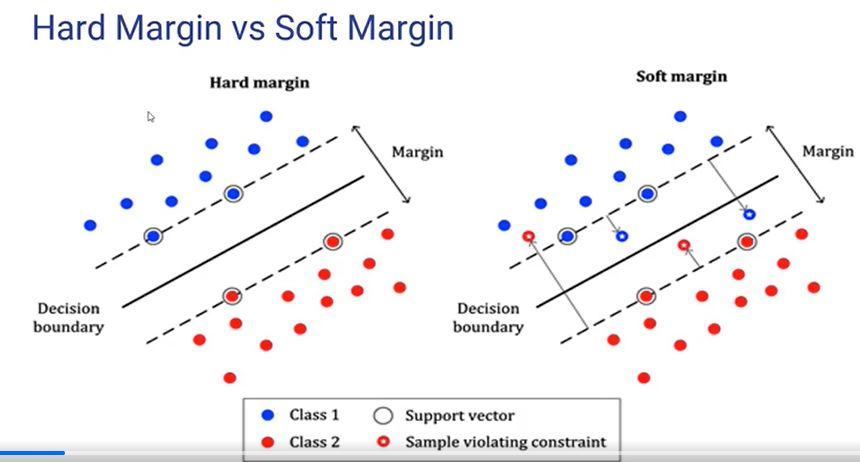
hardvssoft.JPG
- **Soft Margin**: Allowing some **misclassification** to add more bias to our model which lead to better performance.
- We can use cross Validation to determine the optimal size of margins
- **Soft Margins** is Support Vector Classifier which is different than Hard Margins( Maximal Margin classifier)
- In case of having mixed and complex classes, hyperplanes cannot sepearet classes. So, instead of SV classifier we have to use **SV machine** through the use of kernels.
- **Kernels** allow us to project the data to a higher dimension in order to use a hyper plane to separate out the data.

### SVM Parameters:
#### C:float, default=1.0
Regularization parameter. The strength of the regularization is inversely proportional to original C. It is positive. The penalty is a squared l2 penalty.
If C is closer to zero, it lets more data points in Margin(Less restricted).

####  kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
Specifies the kernel type to be used in the algorithm. 

degreeint, default=3
Degree of the polynomial kernel function (‘poly’). Must be non-negative. Ignored by all other kernels.

gamma{‘scale’, ‘auto’} or float, default=’scale’
Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.

Gamma defines how much influence a single training example has. So that means as Gamma gets larger, the closer the other examples have to be in order to be affected.for an extreme value of gamma margin is picking up a ton of information, essentially overfitting to your data.
more influence per support vector, which is why you start to get margin really fitting to all the support vectors.

if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,

if ‘auto’, uses 1 / n_features

if float, must be non-negative.

Recommendation on Using different Kernels:
First use rbf with different C and gamma then go for other kernels like sigmoid or poly
Always use grid search for finding best param.


In [46]:
#Regularization
# Dummies
# scaler
classifier_svc = Pipeline([('scalre', StandardScaler())   #First: StandardScaler
                       #,('',),                         #Second:dummies
                       ,('svc', SVC())])

param_svc = [{'svc__C': [1, 0.1, 0.01 ]  
            ,'svc__kernel': [ 'rbf', 'sigmoid',  'linear'] 
           # ,'svc__degreeint': [ 1, 2,  3, 4] 
            ,'svc__gamma': [ 'scale', 'auto'] 
            },
             {'svc__C': [1, 0.1, 0.01 ]  
            ,'svc__kernel':  ['poly']
            ,'svc__degree': [ 1, 2,  3, 4] 
            
                 }]

In [47]:
### Cross Validation on Logistic KNN

accuracies = cross_val_score(classifier_svc, X = X_train, y=y_train, cv=5)
print(accuracies)
accuracies.mean()

[0.99153738 0.99576869 0.99647391 0.99506347 0.9922426 ]


0.9942172073342735

#### Now we are sure that our accuracy was not based on chance, therfore we trian the model again but this on whole train data.


## Grid search

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

def fit_accuracy(sensor_name, pipe, parameters, X_train, X_test, y_train, y_test):
    
    # GridSearch
    classifier = GridSearchCV(pipe, parameters, cv = 5)
    
    
    # Fitting the model
    classifier.fit(X_train,y_train)

    # Prdeiction
    y_pred = classifier.predict(X_test)

    # Confusion Matrix and accuracy
    
    confusion_mat = confusion_matrix(y_test, y_pred)
    print(100*'-')
    print('\n\n','***',sensor_name,'***','\n\n')
    print('Best Parameters => \n',classifier.best_params_,'\n')
    print('Confusion Matrix => \n',confusion_mat,'\n')
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy Score =>',accuracy,'\n')
    
    # Precision and recall
    
    print('Classification Report =>\n',classification_report(y_test,y_pred)) 
    print(100*'-')
    return y_pred, accuracy 

## Recall Vs Precision

Recall = True Posotive/ Total Actual Positive
Note:
zero or low recall alerts you that the model is not catching any relevant cases or in other words it is over fitted.(This is the case if your model predicted all outcome as the majority class)

Precision = True Posotive/ Total Predicted Positive



In [49]:
# All features
y_pred, accuracy = fit_accuracy('All sensors', classifier_svc, param_svc, X_train, X_test, y_train, y_test)
# Just Tempreture
y_pred_temp, accuracy_temp = fit_accuracy('temperature', classifier_svc, param_svc, X_train_temp, X_test_temp, y_train, y_test)
# Just Light
y_pred_light, accuracy_light = fit_accuracy('light', classifier_svc, param_svc, X_train_light, X_test_light, y_train, y_test)
# Just Sound
y_pred_sound, accuracy_sound = fit_accuracy('sound', classifier_svc, param_svc, X_train_sound, X_test_sound, y_train, y_test)
# Just CO2
y_pred_co2, accuracy_co2 = fit_accuracy('CO2', classifier_svc, param_svc, X_train_co2, X_test_co2, y_train, y_test)
# Just PIR
y_pred_pir, accuracy_pir = fit_accuracy('PIR', classifier_svc, param_svc, X_train_pir, X_test_pir, y_train, y_test)


----------------------------------------------------------------------------------------------------


 *** All sensors *** 


Best Parameters => 
 {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'} 

Confusion Matrix => 
 [[2472    0    0    0]
 [   0  129    2    0]
 [   0    1  229    9]
 [   1    0    6  190]] 

Accuracy Score => 0.993747943402435 

Classification Report =>
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2472
           1       0.99      0.98      0.99       131
           2       0.97      0.96      0.96       239
           3       0.95      0.96      0.96       197

    accuracy                           0.99      3039
   macro avg       0.98      0.98      0.98      3039
weighted avg       0.99      0.99      0.99      3039

----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------

C:\Users\Asus\anaconda3\envs\tensor_playground\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\envs\tensor_playground\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\envs\tensor_playground\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [ ]:
# 

In [23]:
# # Template:
# # 2- KNN

# from sklearn.neighbors import KNeighborsClassifier

# #Regularization
# # Dummies
# # scaler
# from sklearn.neighbors import KNeighborsClassifier
# classifier_knn = Pipeline([('scalre', StandardScaler())   #First: StandardScaler
#                        #,('',),                         #Second:dummies
#                        ,('knn', KNeighborsClassifier(n_neighbors=5))])

# ### Cross Validation on Logistic KNN

# accuracies = cross_val_score(classifier_knn, X = X_train, y=y_train, cv=5)
# print(accuracies)
# accuracies.mean()

# #### Now we are sure that our accuracy was not based on chance, therfore we trian the model again but this on whole train data.

# classifier_knn.fit(X_train,y_train)

# y_knn_pred = classifier_knn.predict(X_test)

# # Confusion Matrix and accuracy
# from sklearn.metrics import confusion_matrix, accuracy_score
# cm = confusion_matrix(y_test, y_knn_pred)
# print('Confusion Matrix => \n',cm,'\n')
# print('Accuracy Score =>',accuracy_score(y_test, y_knn_pred),'\n')

# # Precision and recall
# from sklearn.metrics import classification_report
# print('Classification Report =>\n',classification_report(y_test,y_knn_pred)) 



## Bias-Variance Trade off

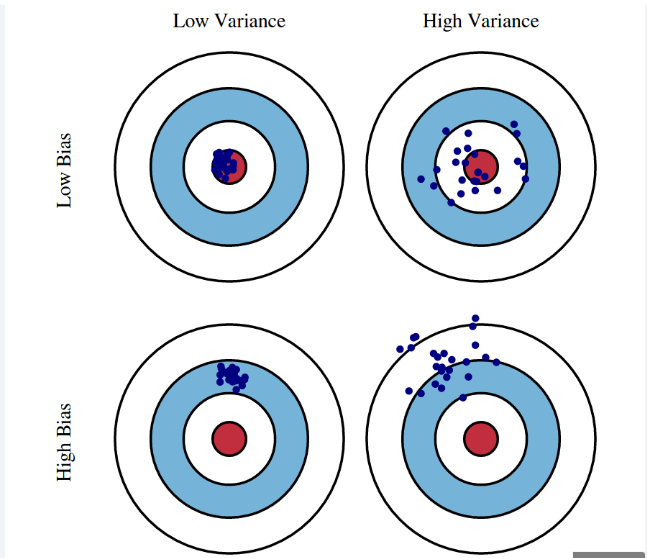

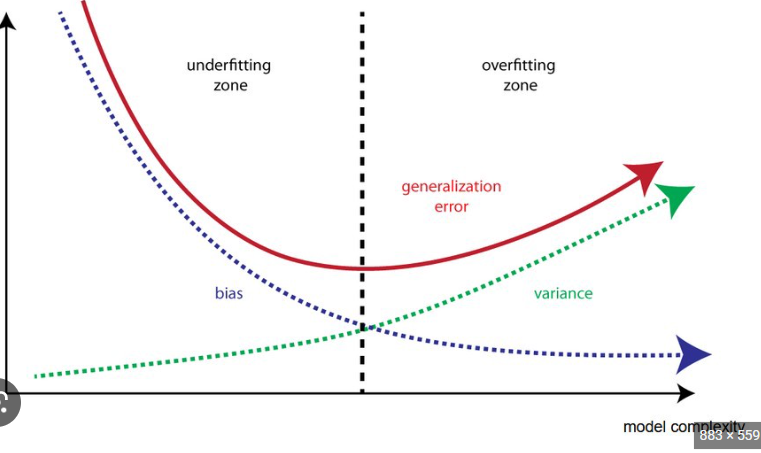

